<a href="https://colab.research.google.com/github/HwiTran/Vietnamese-text-sentiment-classification/blob/main/PhoBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download dataset
Vietnamese Students' Feedback Corpus (UIT-VSFC) is the resource consists of over 16,000 sentences which are human-annotated with two different tasks: sentiment-based and topic-based classifications.

[1] Kiet Van Nguyen, Vu Duc Nguyen, Phu Xuan-Vinh Nguyen, Tham Thi-Hong Truong, Ngan Luu-Thuy Nguyen, UIT-VSFC: Vietnamese Students' Feedback Corpus for Sentiment Analysis,  2018 10th International Conference on Knowledge and Systems Engineering (KSE 2018), November 1-3, 2018, Ho Chi Minh City, Vietnam

In [1]:
!pip install transformers datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install evaluate

In [2]:
!pip install simpletransformers==0.65.1

In [3]:
from datasets import load_dataset

dataset = load_dataset("uitnlp/vietnamese_students_feedback")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Train set exploration

In [4]:
train_set = dataset['train']
train_set

Dataset({
    features: ['sentence', 'sentiment', 'topic'],
    num_rows: 11426
})

In [5]:
train_set[0]

{'sentence': 'slide giáo trình đầy đủ .', 'sentiment': 2, 'topic': 1}

In [6]:
len(train_set)

11426

In [7]:
# Unique labels
set(train_set['sentiment'])

{0, 1, 2}

In [8]:
# Unique labels
set(train_set['topic'])

{0, 1, 2, 3}

In [9]:
train_df = train_set.to_pandas()
train_df.head()

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#Save data for using in future
#train_df.to_csv('/content/drive/MyDrive/NLP/week 7/data/train.csv', index=False)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11426 non-null  object
 1   sentiment  11426 non-null  int64 
 2   topic      11426 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 267.9+ KB


<Axes: ylabel='count'>

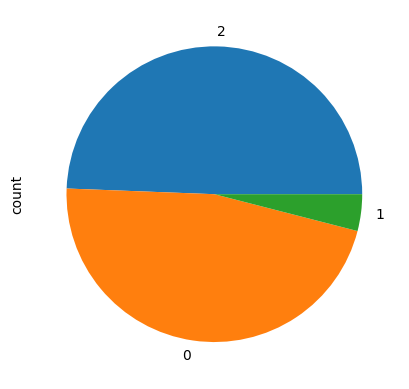

In [13]:
train_df['sentiment'].value_counts().plot(kind='pie')

## Test set exploration

In [14]:
test_set = dataset['test']
test_set

Dataset({
    features: ['sentence', 'sentiment', 'topic'],
    num_rows: 3166
})

In [15]:
test_set[0]

{'sentence': 'nói tiếng anh lưu loát .', 'sentiment': 2, 'topic': 0}

In [16]:
len(test_set)

3166

In [17]:
test_df = test_set.to_pandas()
test_df.head()

,sentence,sentiment,topic
0,nói tiếng anh lưu loát .,2,0
1,giáo viên rất vui tính .,2,0
2,cô max có tâm .,2,0
3,"giảng bài thu hút , dí dỏm .",2,0
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",0,0


<Axes: ylabel='count'>

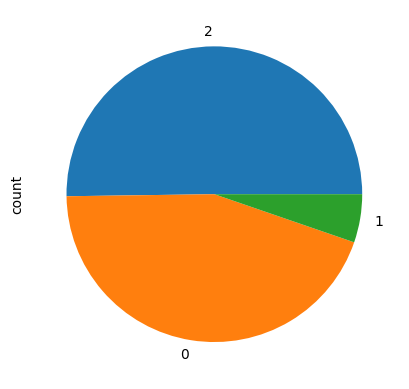

In [18]:
test_df['sentiment'].value_counts().plot(kind='pie')

In [19]:
#Save data for using in future
#test_df.to_csv('/content/drive/MyDrive/NLP/week 7/data/test.csv', index=False)

# Extract Features and Labels

In [20]:
train_texts = train_df['sentence'].values.tolist()
train_labels = train_df['sentiment'].values.tolist()

test_texts = test_df['sentence'].values.tolist()
test_labels = test_df['sentiment'].values.tolist()

#Split the training sample into train and validation set

In [21]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2,random_state=42,stratify=train_labels)

# **MODELING**

## Import required transformer libraries

In [22]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer,TrainingArguments

## Tokenization

In [23]:
#Load pretrained tokenizer
#

# Sử dụng PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True,return_tensors = 'pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Turn labels and encodings into a Dataset object

In [25]:
import torch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
## Test Dataset
class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

In [26]:
#Convert tokenized data into a torch dataset
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentTestDataset(test_encodings)

## Define a Metrics Function

In [27]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)

    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy": accuracy,"f1_score":f1}

##Define Training Arguments

In [28]:
training_args = TrainingArguments(
    output_dir="my_model",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
#Check model layer
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Fine-tuning with Trainer

In [31]:
trainer = Trainer(
    model=model,#
    args=training_args, # training arguments, defined above
    train_dataset=train_dataset,# training dataset
    eval_dataset=val_dataset , # evaluation dataset
    compute_metrics=compute_metrics,
)



In [32]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-25-e895f44c7661>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.384100,0.270874,0.920822,0.901911


TrainOutput(global_step=572, training_loss=0.3696930091697853, metrics={'train_runtime': 331.3058, 'train_samples_per_second': 27.588, 'train_steps_per_second': 1.727, 'total_flos': 765608656249080.0, 'train_loss': 0.3696930091697853, 'epoch': 1.0})

## Evaluate the Trainer based on Validation Datasets

In [33]:
trainer.evaluate()

<ipython-input-25-e895f44c7661>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.27087441086769104,
 'eval_accuracy': 0.92082239720035,
 'eval_f1_score': 0.9019105639190133,
 'eval_runtime': 11.2149,
 'eval_samples_per_second': 203.837,
 'eval_steps_per_second': 12.751,
 'epoch': 1.0}

## Make predictions on TEST DATA

In [34]:
test_df['Sentiment'] = 0
test_texts = test_df['sentence'].values.tolist()
test_labels = test_df['sentiment'].values.tolist()

test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')
test_dataset = SentimentDataset(test_encodings, test_labels)
preds = trainer.predict(test_dataset=test_dataset)

<ipython-input-25-e895f44c7661>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [35]:
probs = torch.from_numpy(preds[0]).softmax(1)

predictions = probs.numpy()# convert tensors to numpy array

In [36]:
import pandas as pd
new_df = pd.DataFrame(predictions,columns=['Negative','Neutral','Positive'])
new_df.head()

,Negative,Neutral,Positive
0,0.019811,0.034510,0.945678
1,0.007045,0.012982,0.979973
2,0.007107,0.016514,0.976379
3,0.937872,0.023336,0.038792
4,0.965947,0.016688,0.017365


## Defining function to format prediction labels

In [37]:
def labels(x):
  if x == 0:
    return 'Negative'
  elif x == 1:
    return 'Neutral'
  else:
    return 'Positive'

results = np.argmax(predictions,axis=1)
test_df['Sentiment'] = results
test_df['Sentiment'] = test_df['Sentiment'].map(labels)
test_df.head(20)

,sentence,sentiment,topic,Sentiment
0,nói tiếng anh lưu loát .,2,0,Positive
1,giáo viên rất vui tính .,2,0,Positive
2,cô max có tâm .,2,0,Positive
3,"giảng bài thu hút , dí dỏm .",2,0,Negative
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",0,0,Negative
5,thầy dạy nhiệt tình và tâm huyết .,2,0,Positive
6,tính điểm thi đua các nhóm .,2,1,Negative
7,thầy nhiệt tình giảng lại cho học sinh .,2,0,Positive
8,có đôi lúc nói hơi nhanh làm sinh viên không t...,0,0,Negative
9,"giảng dạy nhiệt tình , liên hệ thực tế khá nhi...",2,0,Positive


In [38]:
trainer.save_model("/content/drive/MyDrive/NLP/week 7/BERT /my_model")

# Inference

In [39]:
import torch

def predict_sentiment(text, tokenizer, model, id2label):
    # Encode the input text
    encoding = tokenizer(text, return_tensors="pt")
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    # Get model outputs
    with torch.no_grad():
        outputs = model(**encoding)

    # Get logits and convert to probabilities
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)

    # Get the label with the highest probability
    predicted_label_id = torch.argmax(probabilities, dim=1).item()
    predicted_label = id2label[predicted_label_id]

    return predicted_label


id2label = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}

text = "rất là vui luôn"
sentiment = predict_sentiment(text, tokenizer, model, id2label)
print(sentiment)


POSITIVE
